# Midterm (MACS 30100), February 5, 2018
### Nora Nickels
You will have an hour and thirty minutes to take this exam.
1. Put your name in the space provided above (without the brackets).
2. Download this notebook and accompanying data `LenderDataLong.dta`.
3. The class will disconnect their wi-fi and begin taking the exam.
4. The exam is open computer, closed internet, open note.
5. Once you are done, you will signal to a TA or instructor to come over and monitor while you reconnect to the internet and upload your edited notebook to Canvas.

Remember that you must clearly indicate your answers to all questions below. We will give partial credit for partially correct answers. The midterm is worth 20 points (2 problem sets).

## The data
This two exercises of this midterm and all their respective subparts will use the `LenderData.csv` dataset, which contains observations of characteristics on short-term, high interest rate, lender information. You are not to use this data outside of this class. It is a jittered and randomized version of a dataset used in a published research paper.

Each observation contains characteristics of a particular lender location Read it into Python using the `pandas.read_csv()` command. The variables are the following:

* `avgrate`: average annualized interest rate of all loans in percentage points (235 = two hundred and thirty five percent)
* `numstores`: number of other stores owned by the same owner (measure of size)
* `defrate`: default rate on loans from that store during 2010
* `pdrad3`: number of payday lenders within a three-mile radius of the store (measure of competition)
* `pnrad3`: number of pawn lenders within a three-mile radius of the store (measure of competition)
* `totrad3`: total number of other lenders within a three-mile radius of the store (measure of competition)
* `unrt_zip`: unemployment rate in the zip code of the store
* `medtotinc2010`: median total household income in the zip code of the store
* `edbachplus_zip`: average education level in years of schooling of heads of household in the zip code of the store
* `pop_zip`: population in zip code of the store
* `mdage_zip`: median age (in years) in zip code of the store
* `pctblk2_zip`: percent of the population that is black in the zip code of the store in percentage points (2.2=two point two percent)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

# This next command is specifically for Jupyter Notebook
%matplotlib notebook

# Read in the data

lenderdata = pd.read_csv('LenderData.csv', na_values = "?")
lenderdata.head()

,avgrate,numstores,defrate,pdrad3,pnrad3,totrad3,unrt_zip,medtotinc2010,edbachplus_zip,pop_zip,mdage_zip,pctblk2_zip
0,521.429993,23,24.390244,7,3,12,5.7,38485.44531,40.2,44821,33.6,1.0
1,521.429993,23,38.596489,15,2,18,7.1,31289.11133,14.1,68295,29.2,2.2
2,521.429993,23,38.954868,6,3,11,7.1,31289.11133,14.1,68295,29.2,2.2
3,521.429993,23,27.352297,28,29,58,9.2,31421.22266,11.3,26524,28.5,1.4
4,521.429993,23,30.055660,22,17,42,7.5,27502.00000,22.3,28936,30.8,2.7


## 1. Using the distributions of interest rates and median income (10 points)

1A) [2 points] Create a plot of the histogram of high interest rate lenders interest rates `avgrate`. Use 30 bins. Make sure to label your axes and give the figure a title. If you had to group lenders into $N$ categories, how many categories would you choose based on the interest rate data? That is, how many groupings to you see in these data?

<IPython.core.display.Javascript object>


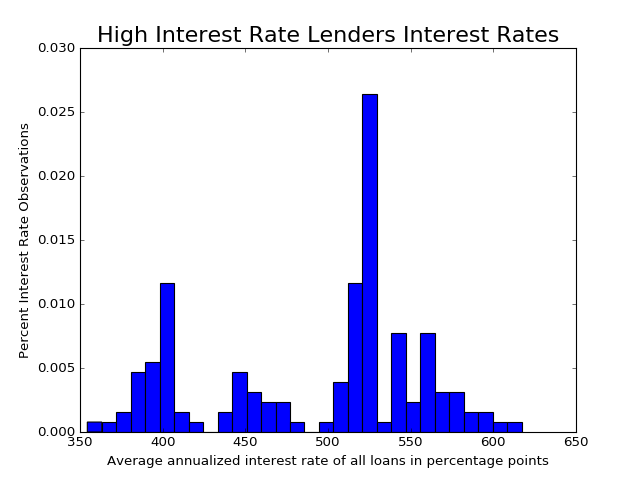

In [2]:
# Create a histogram of interest rates

count, bins, ignored = plt.hist(lenderdata.avgrate, 30, edgecolor='black', normed=True)
plt.title('High Interest Rate Lenders Interest Rates', fontsize=20)
plt.xlabel('Average annualized interest rate of all loans in percentage points')
plt.ylabel('Percent Interest Rate Observations')

### 1A Answer: I see three groupings in this data. If I had to group lenders into N categories, I would group them into three categories based on this interest rate data.

1B) [1 point] Create a plot of the histogram of median total household income `medtotinc2010`. Use 30 bins. Make sure to label your axes and give the figure a title.

<IPython.core.display.Javascript object>


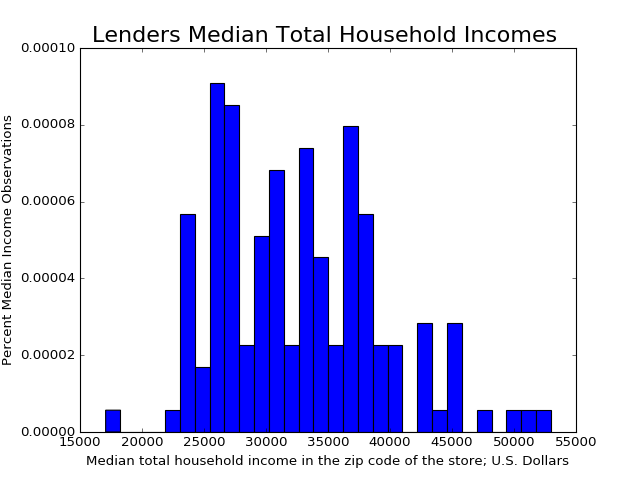

In [3]:
# Plot a second histogram.

plt.figure()
count, bins, ignored = plt.hist(lenderdata.medtotinc2010, 30, edgecolor='black', normed=True)
plt.title('Lenders Median Total Household Incomes ', fontsize=20)
plt.xlabel('Median total household income in the zip code of the store; U.S. Dollars')
plt.ylabel('Percent Median Income Observations')

### 1B Answer: See histogram above.

1C) [5 points] Use maximum likelihood estimation to fit a lognormal distribution $LN(\mu, \sigma)$ to the median income data `medtotinc2010`. Report your estimated $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$ as well as the likelihood function value at the maximum (not the negative log likelihood). Report your estimate of the variance-covariance matrix of your maximum likelihood estimates of $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$. Report the standard error on the estimate for $\hat{\mu}_{mle}$.

In [4]:
income_mean = lenderdata['medtotinc2010'].mean()
print(income_mean)

32772.13539034014


In [5]:
income_std = lenderdata['medtotinc2010'].std()
print(income_std)

6639.982466378221


In [7]:
# Define function that generates values of a potentially lognormal
# probability density function (PDF)
def lognorm_pdf(xvals, mu, sigma, cutoff):
    
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(0, loc=mu, s=sigma, scale=1)
    else:
        prob_notcut = (sts.lognorm.cdf(cutoff, loc=mu, s=sigma, scale=1) -
                       sts.lognorm.cdf(0, loc=mu, s=sigma, scale=1))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

dist_inc = np.linspace(1e-10, 55000, 200)
mu_1 = 10
sig_1 = 0.2

In [8]:
# Define log likelihood function for the lognormal distribution

def log_lik_lognorm(xvals, mu, sigma, cutoff):
    pdf_vals = lognorm_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood 1: ', log_lik_lognorm(lenderdata.medtotinc2010, mu_1, sig_1, 'None'))

Log-likelihood 1:  -1758.793007042861


In [9]:
# c. Estimate the parameters of the lognormal distribution by MLE and plot PDF against PDF and histogram from parts a and b.

def crit(params, *args):
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_lognorm(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

### 1C Answer: Report your estimated μ^mle  and  σ̂ mle.

In [10]:
# Report the ML estimates for mu and sigma.

import scipy.optimize as opt

mu_init = 10  # mu_1
sig_init = 0.2 # sig_1
params_init = np.array([mu_init, sig_init])
mle_args = (lenderdata.medtotinc2010, 'None')
results = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B',
                       bounds=((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)
results

mu_MLE= 10.377380189  sig_MLE= 0.19949927867


      fun: 1497.1030088862117
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.59161573e-04,  -4.54747351e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 7
   status: 0
  success: True
        x: array([ 10.37738019,   0.19949928])

### 1C Answer: Report likelihood function value at the maximum

In [11]:
# Report the value of likelihood.

print('Log-likelihood 1: ', log_lik_lognorm(lenderdata.medtotinc2010, mu_1, sig_1, 150000))
print('MLE log-likelihood 3: ', log_lik_lognorm(lenderdata.medtotinc2010, mu_MLE, sig_MLE, 150000))

Log-likelihood 1:  -1758.793007042861
MLE log-likelihood 3:  -1497.1030088862117


### 1C Answer: Report estimate of the variance-covariance matrix of your maximum likelihood estimates and standard error for mu and sigma estimates.

In [12]:
# Variance covariance matrix.

results
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[ 0.00027258 -0.00027258]
 [-0.00013395  0.00013395]]
Standard error for mu estimate =  0.0165101403947
Standard error for sigma estimate =  0.0115735973989


### 1C: Likelihood ratio test.

In [13]:
Perform a likelihood ratio test. 

log_lik_h0 = log_lik_lognorm(lenderdata.medtotinc2010, mu_1, sig_1, 150000)
log_lik_mle = log_lik_lognorm(lenderdata.medtotinc2010, mu_MLE, sig_MLE, 150000)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)
print(LR_val)

chi squared of H0 with 2 degrees of freedom p-value =  0.0
523.3799963132988


1D) [2 points] Plot the predicted distribution from your maximum likelihood estimates $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$ against the histogram of the data.

### 1D Answer: Below histogram with predicted distribution.

<IPython.core.display.Javascript object>


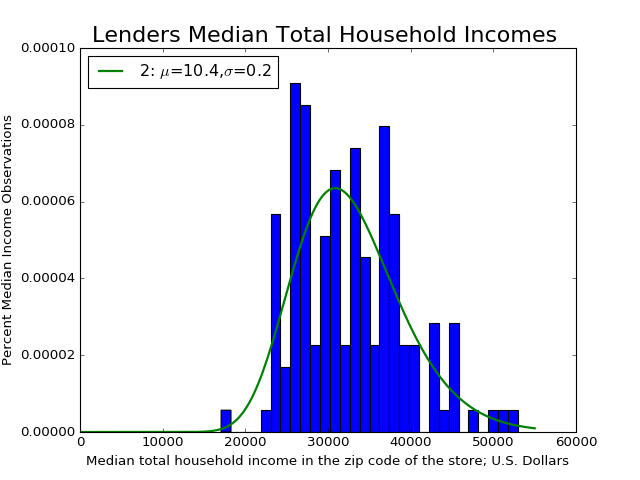

In [17]:
dist_inc = np.linspace(1e-10, 55000, 200)
plt.figure()
count, bins, ignored = plt.hist(lenderdata.medtotinc2010, 30, edgecolor='black', normed=True)
plt.title('Lenders Median Total Household Incomes ', fontsize=20)
plt.xlabel('Median total household income in the zip code of the store; U.S. Dollars')
plt.ylabel('Percent Median Income Observations')
plt.plot(dist_inc, lognorm_pdf(dist_inc, mu_MLE, sig_MLE, 55000),
         linewidth=2, color='g', label='2: $\mu$=10.4,$\sigma$=0.2')
plt.legend(loc='upper left')

## 2. Determinants of lender interest rates (10 points)

2A) [3 points] Assume a simple regression model of four factors that influence the interest rates that a lender charges, namely, number of stores, default rate in the area, unemployment rate in the area, and median household income in the area.

$$ avgrate_i = \beta_0 + \beta_1 numstores_i + \beta_2 defrate_i + \beta_3 unrt_zip_i + \beta_4 medtotinc2010_i + u_i $$

Estimate this model by OLS using the `statsmodels.api` package. Don't forget to include a constant. Print your results summary. Which variables are significant at the 5-percent level? How would you interpret in words the estimated coefficient on `numstores`?

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [19]:
lenderdata['const'] = 1

reg1 = sm.OLS(lenderdata['avgrate'], lenderdata[['const', 'numstores', 'defrate', 'unrt_zip', 'medtotinc2010']], missing='drop')
type(reg1)
results = reg1.fit()
type(results)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                avgrate   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.375
Date:                Mon, 05 Feb 2018   Prob (F-statistic):            0.00229
Time:                        13:02:15   Log-Likelihood:                -812.28
No. Observations:                 147   AIC:                             1635.
Df Residuals:                     142   BIC:                             1650.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const           453.4117     51.263      8.845

### 2A answer: The coefficient for the variable for number of stores in the area is the only variable significant at the 5% level. Keeping all else constant, a single unit change in number of stores (AKA, one store) results in a -2.6278 percent decrease in average annualized interest rate of all loans.

2B) [4 points] Now assume a richer model for the determinants of lender interest rates, which includes the following measures of competition and other demographic variables.

$$ avgrate_i = \beta_0 + \beta_1 numstores_i + \beta_2 defrate_i + \beta_3 unrt_zip_i + \beta_4 medtotinc2010_i + ... $$
$$ \qquad\qquad\qquad\qquad \beta_5 totrad3_i + \beta_6 edbachplus\_zip_i + \beta_7 pop\_zip_i + \beta_8 mdage\_zip_i + \beta_9 pctblk2\_zip_i + u_i $$

Estimate this regression by OLS using the `statsmodels.api` package. In controlling for these new varaibles, do any of the originally estimated coefficients from the model in part (2A) become statistically not significant (at the 5 percent level)? Of these new coefficients ($\beta_5$ through $\beta_9$), which one(s) are the most statistically significant?

In [20]:
reg2 = sm.OLS(lenderdata['avgrate'], lenderdata[['const', 'numstores', 'defrate', 'unrt_zip', 'medtotinc2010', 'totrad3', 'edbachplus_zip', 'pop_zip', 'mdage_zip', 'pctblk2_zip']], missing='drop')

results2 = reg2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                avgrate   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     2.846
Date:                Mon, 05 Feb 2018   Prob (F-statistic):            0.00419
Time:                        13:02:20   Log-Likelihood:                -808.23
No. Observations:                 147   AIC:                             1636.
Df Residuals:                     137   BIC:                             1666.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const            613.9741     85.491      7.

### 2B Answer: The originally estimated coefficient for number of stores (the only statistically significant originally estimate coefficient) remains statistically significant at the 5% level. Of the new coefficients, the estimated coefficient for average education level in years of schooling of heads of household in the zip code of the store is the most statistically significant, and it is the only new coefficient that is statistically significant at the 5% level.

2C) [3 points] Create a new binary variable called `avgrate_high` that equals 1 if `avgrate` > 490, and equals 0 otherwise. Estimate a logistic regression using the `statsmodels.api` package. Let $X\beta$ be the linear coefficients and variables from the model from part (2B).

$$ Pr(avgrate\_high=1|X\beta) = \frac{X\beta}{1 + X\beta} $$

Report the variables whose coefficients are estimated to be significant at the 5-percent level.

In [21]:
# Create a binary variable of avgrate_high

lenderdata['avgrate_high'] = lenderdata['avgrate'].apply(lambda x: 1 if x > 425 else 0)
lenderdata.head()

,avgrate,numstores,defrate,pdrad3,pnrad3,totrad3,unrt_zip,medtotinc2010,edbachplus_zip,pop_zip,mdage_zip,pctblk2_zip,const,avgrate_high
0,521.429993,23,24.390244,7,3,12,5.7,38485.44531,40.2,44821,33.6,1.0,1,1
1,521.429993,23,38.596489,15,2,18,7.1,31289.11133,14.1,68295,29.2,2.2,1,1
2,521.429993,23,38.954868,6,3,11,7.1,31289.11133,14.1,68295,29.2,2.2,1,1
3,521.429993,23,27.352297,28,29,58,9.2,31421.22266,11.3,26524,28.5,1.4,1,1
4,521.429993,23,30.055660,22,17,42,7.5,27502.00000,22.3,28936,30.8,2.7,1,1


In [22]:
# Drop unnecessary variables.

logit_lender = lenderdata.drop(['pdrad3','pnrad3','totrad3','avgrate'], 1)
logit_lender.head()

,numstores,defrate,unrt_zip,medtotinc2010,edbachplus_zip,pop_zip,mdage_zip,pctblk2_zip,const,avgrate_high
0,23,24.390244,5.7,38485.44531,40.2,44821,33.6,1.0,1,1
1,23,38.596489,7.1,31289.11133,14.1,68295,29.2,2.2,1,1
2,23,38.954868,7.1,31289.11133,14.1,68295,29.2,2.2,1,1
3,23,27.352297,9.2,31421.22266,11.3,26524,28.5,1.4,1,1
4,23,30.055660,7.5,27502.00000,22.3,28936,30.8,2.7,1,1


In [23]:
# Define X array variables for logit model.
X = pd.concat((logit_lender.loc[:,"numstores":"pctblk2_zip"], logit_lender.const), axis = 1)

In [47]:
# Estimate the logistic regression with the estimators from 2B.
LogitModel = sm.Logit(logit_lender.avgrate_high, X)
LogitReg_sm = LogitModel.fit()
LogitReg_sm.summary()

Optimization terminated successfully.
         Current function value: 0.324112
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           avgrate_high   No. Observations:                  147
Model:                          Logit   Df Residuals:                      138
Method:                           MLE   Df Model:                            8
Date:                Mon, 05 Feb 2018   Pseudo R-squ.:                  0.4095
Time:                        12:50:00   Log-Likelihood:                -47.644
converged:                       True   LL-Null:                       -80.685
                                        LLR p-value:                 2.950e-11
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
numstores         -0.2449      0.045     -5.415      0.000        -0.334    -0.156
defrate            0.0926      0.036      2.605      0.009         0.023     0.162
unrt_zip           0.1181      0.185      0.638      0.523        -0.245     0.481
medtotinc2010   9.697e-05   6.21e-05      1.561      0.118     -2.48e-05     0.000
edbachplus_zip    -0.0641      0.038     -1.702      0.089        -0.138     0.010
pop_zip        -1.274e-05   2.29e-05     -0.555      0.579     -5.77e-05  3.22e-05
mdage_zip         -0.1863      0.120     -1.551      0.121        -0.422     0.049
pctblk2_zip        0.0651      0.296      0.220      0.826        -0.514     0.644
const              8.2300      4.933      1.668      0.095        -1.439    17.899
==================================================================================
"""

### 2C Answer: The variables whose coefficients are estimated to be statistically significant at the 5% level are defrate (default rate on loans from that store during 2010) and numstores (number of other stores owned by the same owner).